In [9]:
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from scipy.interpolate import RegularGridInterpolator
from FD_functions.functions_3d import f_function_shifted
import numpy as np
from FD_functions.interpolation import interpolate_initial_condition
from astropy.constants import m_p
import rom_operator_inference as roi
import astropy.units as u
import matplotlib.pyplot as plt
from rom_tools import flatten, undo_flatten, normalize_min_max, qDEIM
import scipy.linalg as la
import matplotlib

font = {'family': 'serif',
        'size': 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

# POD (Shifted)


In [10]:
# FOM solution saved.
FOM_SOL = np.load('data/data_shifted.npy')
m = np.load('data/m.npy')
quantities, n_phi, n_theta, n_radial = np.shape(FOM_SOL)
n_radial
print(m)

7.338719759882489e-09


In [11]:
# split into testing and training
l = int(0.7 * n_radial)
# reshape the FOM solution
X_train = FOM_SOL[:, :, :, :l]
X_test = FOM_SOL[:, :, :, l:]

In [12]:
# SVD decomposition
svdvals = la.svdvals(flatten(X_train, np=n_phi, nt=n_theta))


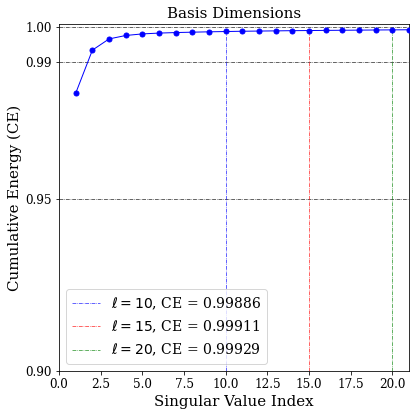

In [13]:
ig, ax = plt.subplots(figsize=(6, 6))
xlim = 21
# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), np.cumsum(svdvals) / np.sum(svdvals), '.-', ms=10, lw=1, zorder=3, c="b")
# get current y-limits
ylim = ax.get_ylim()
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.vlines(10, 0, (np.cumsum(svdvals) / np.sum(svdvals))[10], color="blue", linewidth=.6, linestyle="-.",
          label="$\ell = 10$, CE = " + str(round((np.cumsum(svdvals) / np.sum(svdvals))[10], 5)))
ax.vlines(15, 0, (np.cumsum(svdvals) / np.sum(svdvals))[15], color="red", linewidth=.6, linestyle="-.",
          label="$\ell = 15$, CE = " + str(round((np.cumsum(svdvals) / np.sum(svdvals))[15], 5)))
ax.vlines(20, 0, (np.cumsum(svdvals) / np.sum(svdvals))[20], color="green", linewidth=.6, linestyle="-.",
          label="$\ell = 20$, CE = " + str(round((np.cumsum(svdvals) / np.sum(svdvals))[20], 5)))

_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy (CE)", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend()
plt.tight_layout()
plt.savefig("figs_rom/singular_value_decay_shifted.png", pad_inches=1)
plt.show()

In [22]:
#### SIMULATION -- GALERKIN PROJECTION STEP ######
r = (np.linspace(0.14, 1.1, int(n_radial)) * u.AU).to(u.km)
dr = r[1] - r[0]
# define mesh grid
PHI, THETA = np.meshgrid(np.linspace(0, 2 * np.pi, n_phi), np.linspace(0.05, np.pi - 0.05, n_theta))

---------------
15
---------------
0.14 AU
1 , r = 0.14AU


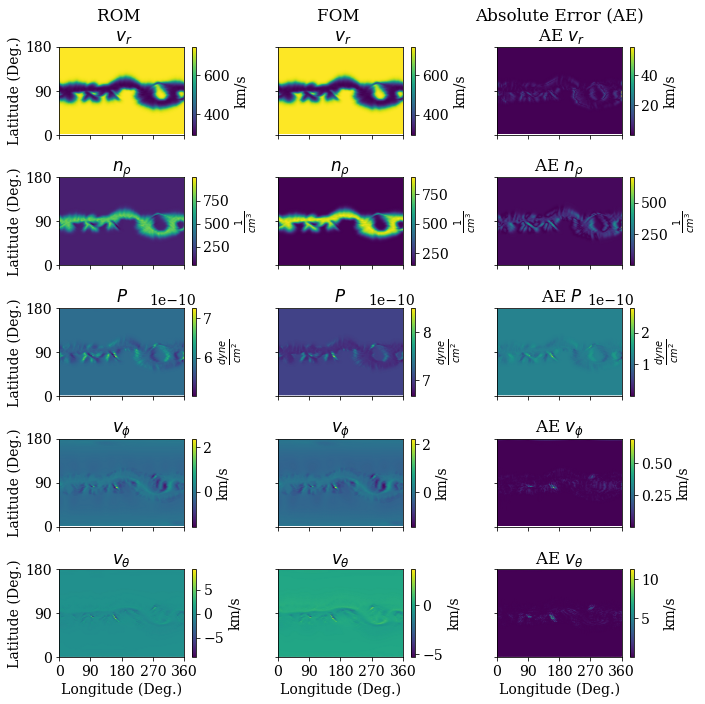

0.1785542168674699 AU
2 , r = 0.18AU


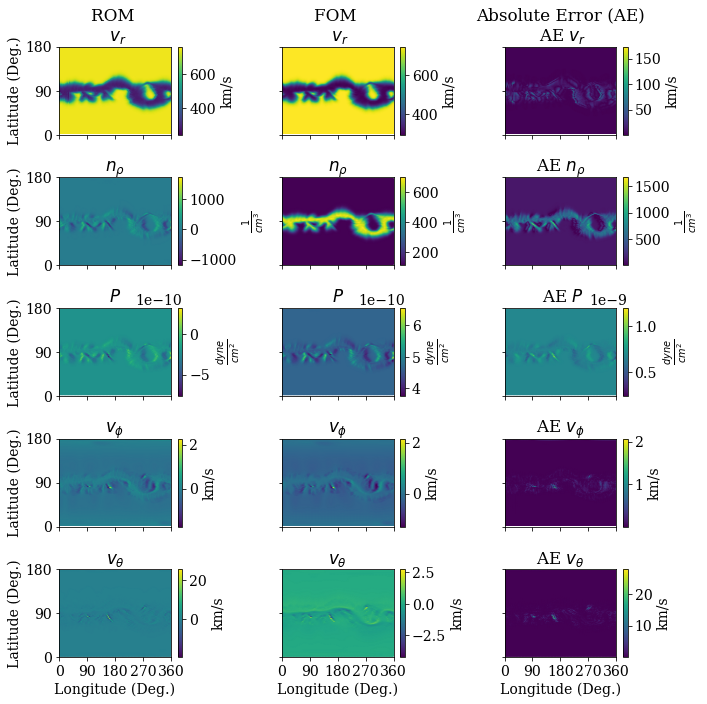

0.21710843373493977 AU
3 , r = 0.22AU


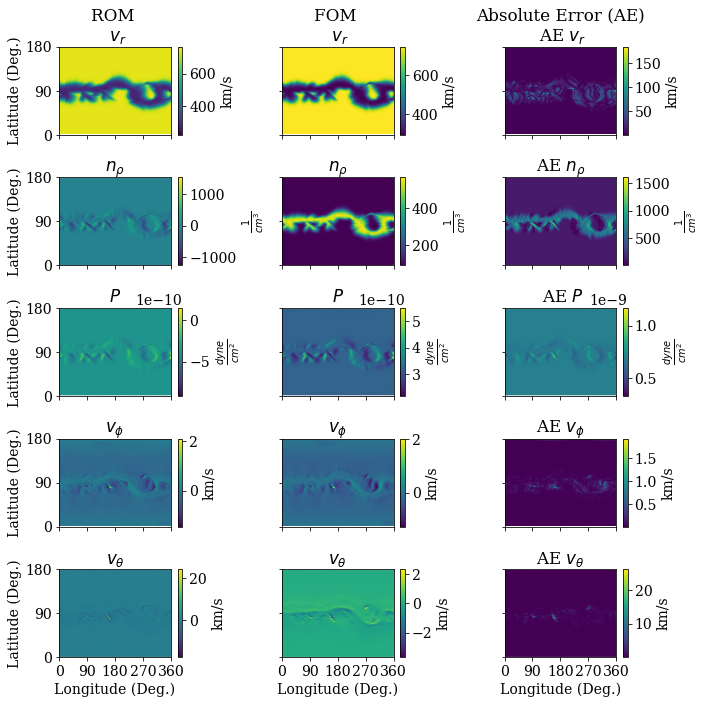

KeyboardInterrupt: 

In [23]:
ell_vector = [15]
error_vector = np.zeros((len(r)-1, len(ell_vector)))
jj=1

for pp in range(len(ell_vector)):
    print("---------------")
    print(ell_vector[pp])
    print("---------------")
    # construct the reduced basis Vr. 
    ell = ell_vector[pp]
    Vr, _ = roi.pre.pod_basis(flatten(X_train, np=n_phi, nt=n_theta), ell, mode="dense")

    ROM_SOL = np.zeros((5, n_phi, n_theta, len(r)))
    ROM_SOL[:, :, :, 0] = FOM_SOL[:, :, :, 0]

    for ii in range(len(r) - 1):
        nonlinear = Vr.T @ flatten(f_function_shifted(U=ROM_SOL[:, :, :, ii],
                                              dp=(2 * np.pi) / n_phi,
                                              dt=np.pi / n_theta,
                                              r=r[ii], THETA=THETA.T, m=m), np=n_phi, nt=n_theta, vector=True)
        
        reduce_solution = Vr.T @ flatten(ROM_SOL[:, :, :, ii],
                                         np=n_phi, nt=n_theta, vector=True) + dr.value * nonlinear
        
        ROM_SOL[:, :, :, ii + 1] = undo_flatten(Vr @ reduce_solution, np=n_phi, nt=n_theta, vector=True)
        
        RE = (ROM_SOL[:, :, :, ii + 1] - FOM_SOL[:, :, :, ii + 1])/(FOM_SOL[:, :, :, ii + 1])
        error_vector[ii, pp] = np.mean(RE)
        
        
        
        if ii % 10 == 0:
            print(r[ii].to(u.AU))
            fig, ax = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(10, 10))
            pos = ax[0, 0].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA, ROM_SOL[0, :, :, ii + 1].T, shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[0, 0])
            cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
            ax[0, 0].set_title(r"$v_{r}$")

            pos = ax[0, 1].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA, FOM_SOL[0, :, :, ii + 1].T, shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[0, 1])
            cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
            ax[0, 1].set_title(r"$v_{r}$")

            pos = ax[0, 2].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA,
                                      np.abs(FOM_SOL[0, :, :, ii + 1].T - ROM_SOL[0, :, :, ii + 1].T), shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[0, 2])
            cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
            ax[0, 2].set_title(r"AE $v_{r}$")

            pos = ax[1, 0].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA,
                                      (ROM_SOL[1, :, :, ii + 1].T / m_p.value * 1 / u.km ** 3).to(1 / u.cm ** 3),
                                      shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[1, 0])
            cbar.ax.set_ylabel(r'$\frac{1}{cm^3}$', rotation=90, fontsize=14)
            ax[1, 0].set_title(r"$n_{\rho}$")

            pos = ax[1, 1].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA,
                                      (FOM_SOL[1, :, :, ii + 1].T / m_p.value * 1 / u.km ** 3).to(1 / u.cm ** 3),
                                      shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[1, 1])
            cbar.ax.set_ylabel(r'$\frac{1}{cm^3}$', rotation=90, fontsize=14)
            ax[1, 1].set_title(r"$n_{\rho}$")

            pos = ax[1, 2].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA,
                                      (np.abs(FOM_SOL[1, :, :, ii + 1].T - ROM_SOL[1, :, :,
                                                                           ii + 1].T) / m_p.value * 1 / u.km ** 3).to(
                                          1 / u.cm ** 3),
                                      shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[1, 2])
            cbar.ax.set_ylabel(r'$\frac{1}{cm^3}$', rotation=90, fontsize=14)
            ax[1, 2].set_title(r"AE $n_{\rho}$")

            pos = ax[2, 0].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA,
                                      (10 * ROM_SOL[2, :, :, ii + 1].T * u.kg / (u.s ** 2 * u.km)).to(u.dyne / u.cm ** 2),
                                      shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[2, 0])
            cbar.ax.set_ylabel(r'$\frac{dyne}{cm^2}$', rotation=90, fontsize=14)
            ax[2, 0].set_title(r"$P$")

            pos = ax[2, 1].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA,
                                      (10 * FOM_SOL[2, :, :, ii + 1].T * u.kg / (u.s ** 2 * u.km)).to(u.dyne / u.cm ** 2),
                                      shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[2, 1])
            cbar.ax.set_ylabel(r'$\frac{dyne}{cm^2}$', rotation=90, fontsize=14)
            ax[2, 1].set_title(r"$P$")

            pos = ax[2, 2].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA,
                                      np.abs(10 * (FOM_SOL[2, :, :, ii + 1].T - ROM_SOL[2, :, :, ii + 1].T) * u.kg / (
                                                  u.s ** 2 * u.km)).to(u.dyne / u.cm ** 2),
                                      shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[2, 2])
            cbar.ax.set_ylabel(r'$\frac{dyne}{cm^2}$', rotation=90, fontsize=14)
            ax[2, 2].set_title(r" AE $P$")

            pos = ax[3, 0].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA, ROM_SOL[3, :, :, ii + 1].T, shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[3, 0])
            cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
            ax[3, 0].set_title(r"$v_{\phi}$")

            pos = ax[3, 1].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA, FOM_SOL[3, :, :, ii + 1].T, shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[3, 1])
            cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
            ax[3, 1].set_title(r"$v_{\phi}$")

            pos = ax[3, 2].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA,
                                      np.abs(FOM_SOL[3, :, :, ii + 1].T - ROM_SOL[3, :, :, ii + 1].T), shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[3, 2])
            cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
            ax[3, 2].set_title(r"AE $v_{\phi}$")

            pos = ax[4, 0].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA, ROM_SOL[4, :, :, ii + 1].T, shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[4, 0])
            cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
            ax[4, 0].set_title(r"$v_{\theta}$")

            pos = ax[4, 1].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA, FOM_SOL[4, :, :, ii + 1].T, shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[4, 1])
            cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
            ax[4, 1].set_title(r"$v_{\theta}$")

            pos = ax[4, 2].pcolormesh(180 / np.pi * PHI, 180 / np.pi * THETA,
                                      np.abs(FOM_SOL[4, :, :, ii + 1].T - ROM_SOL[4, :, :, ii + 1].T), shading='gouraud',
                                      cmap="viridis")
            cbar = fig.colorbar(pos, ax=ax[4, 2])
            cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
            ax[4, 2].set_title(r"AE $v_{\theta}$")

            ax[4, 0].set_xticks([0, 90, 180, 270, 360])
            ax[4, 0].set_yticks([0, 90, 180])
            ax[4, 0].set_xlabel("Longitude (Deg.)")
            ax[4, 1].set_xlabel("Longitude (Deg.)")
            ax[4, 2].set_xlabel("Longitude (Deg.)")
            ax[4, 0].set_ylabel("Latitude (Deg.)")
            ax[4, 0].set_ylabel("Latitude (Deg.)")
            ax[3, 0].set_ylabel("Latitude (Deg.)")
            ax[2, 0].set_ylabel("Latitude (Deg.)")
            ax[1, 0].set_ylabel("Latitude (Deg.)")
            ax[0, 0].set_ylabel("Latitude (Deg.)")

            cols = ['Column {}'.format(col) for col in range(1, 4)]
            for ax, col in zip(ax[0], ["ROM \n $v_{r}$", "FOM \n $v_{r}$", "Absolute Error (AE)\n AE $v_{r}$"]):
                ax.set_title(col)
            # fig.suptitle("r = " + str(round(((new_r[ii]).to(u.AU)).value, 2)) + "AU")
            print(str(jj) + " , r = " + str(round(((r[ii]).to(u.AU)).value, 2)) + "AU")
            plt.tight_layout()
            plt.show()
            fig.savefig("figs_rom/pod-shifted/fig_" + str(jj) + ".png", dpi=400)
            jj += 1
            plt.close()

In [ ]:
r.to(u.AU).value[l]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
for pp in range(len(ell_vector)):
    
    ax.plot(r.to(u.AU).value[:-1], np.abs(error_vector[:, pp]), "--", label="$\ell$ = " + str(int(ell_vector[pp])))
ax.axvline(r.to(u.AU).value[l], c="black", label="Training Ends")
ax.set_yscale("log")
#ax.set_ylim(0, 100)
ax.set_title("POD Sensitivity to Reduced Basis Dimensions")
ax.set_xlabel("Heliocentric Distance (AU)")
ax.set_ylabel("Mean Relative Error")
plt.legend()
plt.savefig("figs_rom/sesitivity_to_ell_shifted.png", dpi=400)

# DEIM

In [ ]:
k_vec = np.arange(20, 200, 50)
error_vector_k = np.zeros((len(r)-1, len(k_vec)))

for pp in range(len(k_vec)):
    U = np.load('data/U_full.npy')
    U = U[:, :k_vec[pp]]
    S, _ = qDEIM(U)
    mat_mul = Vr.T @ U @ np.linalg.inv(S.T @ U) @ S.T
    ROM_SOL_DEIM = np.zeros((5, n_phi, n_theta, len(r)))
    ROM_SOL_DEIM[:, :, :, 0] = FOM_SOL[:, :, :, 0]

    for ii in range(len(r) - 1):
        f_vx = flatten(f_function(U=ROM_SOL_DEIM[:, :, :, ii],
                                  dp=(2 * np.pi) / n_phi,
                                  dt=np.pi / n_theta,
                                  r=r[ii], THETA=THETA.T),
                       np=n_phi, nt=n_theta, vector=True)

        nonlinear = mat_mul @ f_vx

        reduce_solution = Vr.T @ flatten(ROM_SOL_DEIM[:, :, :, ii],
                                         np=n_phi, nt=n_theta, vector=True) + \
                          dr.value * nonlinear

        ROM_SOL_DEIM[:, :, :, ii + 1] = undo_flatten(Vr @ reduce_solution, np=n_phi, nt=n_theta, vector=True)
        RE = (ROM_SOL_DEIM[:, :, :, ii + 1] - FOM_SOL[:, :, :, ii + 1])/(FOM_SOL[:, :, :, ii + 1])
        error_vector_k[ii, pp] = np.mean(RE)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
for pp in range(len(ell_vector)):
    ax.plot(r.to(u.AU).value[:-1], np.abs(error_vector_k[:, pp]), "--", label="$k$ = " + str(int(k_vec[pp])))
ax.axvline(r.to(u.AU).value[l], c="black", label="Training Ends")
ax.set_ylim(0, 100)

ax.set_yscale("log")
ax.set_title("POD-DEIM Sensitivity to Number of Sampling Points")
ax.set_xlabel("Heliocentric Distance (AU)")
ax.set_ylabel("Mean Relative Error")
plt.legend()
plt.savefig("figs_rom/sesitivity_to_k.png", dpi=400)

In [ ]:
U = np.load('data/U_full.npy')
np.shape(U)


In [ ]:
S, _ = qDEIM(U)
np.shape(S)

In [ ]:
mat_mul = Vr.T @ U @ np.linalg.inv(S.T @ U) @ S.T
np.shape(mat_mul)

In [ ]:
ROM_SOL_DEIM = np.zeros((5, n_phi, n_theta, len(r)))
ROM_SOL_DEIM[:, :, :, 0] = FOM_SOL[:, :, :, 0]

jj = 0
for ii in range(len(r) - 1):
    f_vx = flatten(f_function(U=ROM_SOL_DEIM[:, :, :, ii],
                              dp=(2 * np.pi) / n_phi,
                              dt=np.pi / n_theta,
                              r=r[ii], THETA=THETA.T),
                   np=n_phi, nt=n_theta, vector=True)

    nonlinear = mat_mul @ f_vx

    reduce_solution = Vr.T @ flatten(ROM_SOL_DEIM[:, :, :, ii],
                                     np=n_phi, nt=n_theta, vector=True) + \
                      dr.value * nonlinear

    ROM_SOL_DEIM[:, :, :, ii + 1] = undo_flatten(Vr @ reduce_solution, np=n_phi, nt=n_theta, vector=True)